In [2]:
import json
import time

import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from IPython import display
from tensorflow import keras
from IPython.display import Image
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# tf.keras.utils.get_file("/content/img_align_celeba.zip",
#                         origin="https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/gans/img_align_celeba.zip",
#                         extract=True,
#                         cache_subdir="/content")

'C:/content/img_align_celeba.zip'

In [4]:
img_generator = ImageDataGenerator(
    rescale=1/255., 
)

In [5]:
BATCH_SIZE = 64

In [23]:
directory_generator = img_generator.flow_from_directory(
    directory = "/content/img", 
    target_size = (64,64),
    
)

Found 202599 images belonging to 1 classes.


Label : img_align_celeba


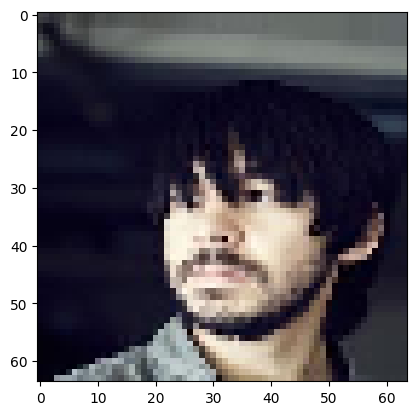

Label : img_align_celeba


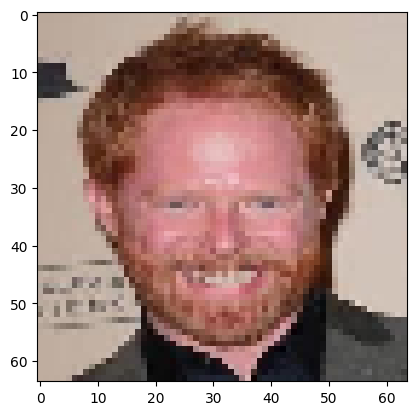

Label : img_align_celeba


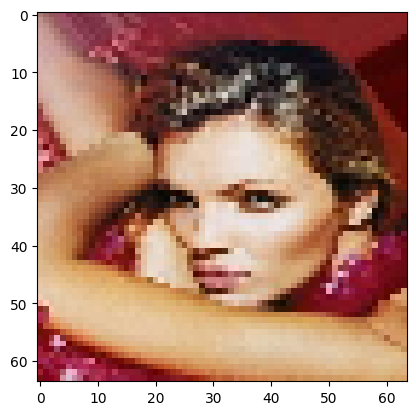

Label : img_align_celeba


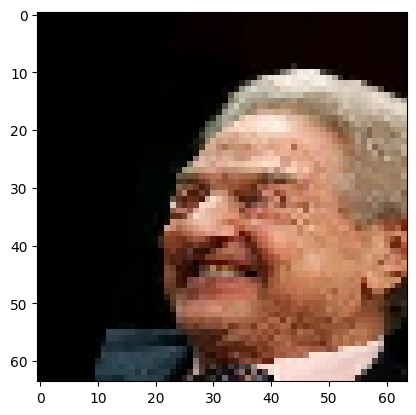

Label : img_align_celeba


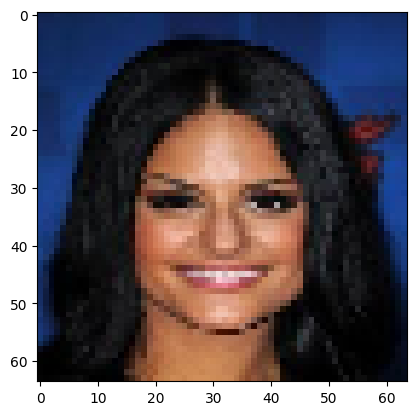

Label : img_align_celeba


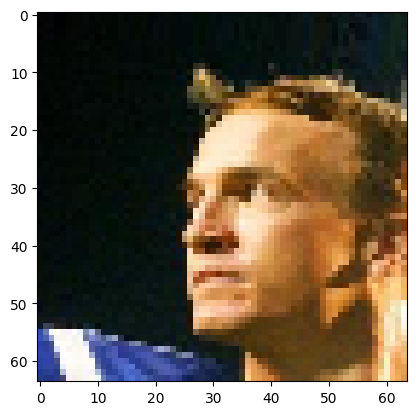

Label : img_align_celeba


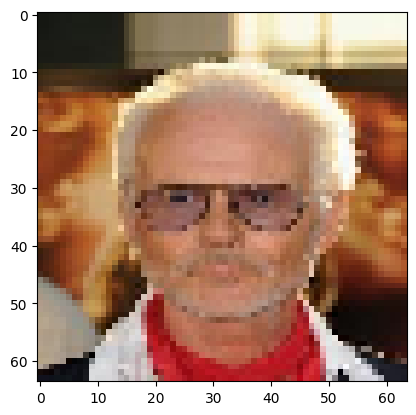

Label : img_align_celeba


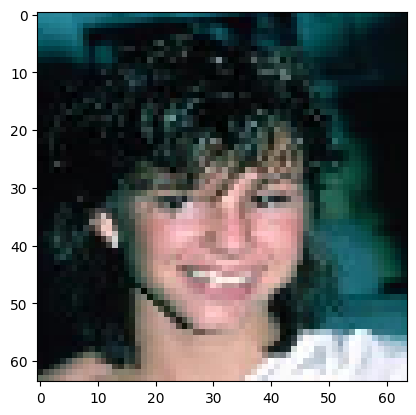

Label : img_align_celeba


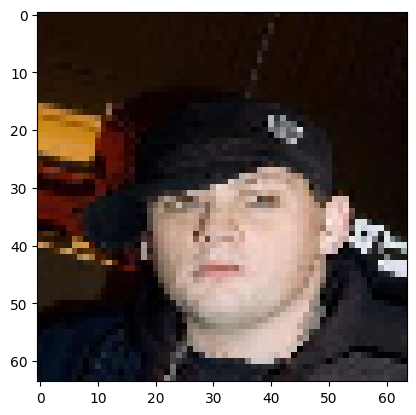

Label : img_align_celeba


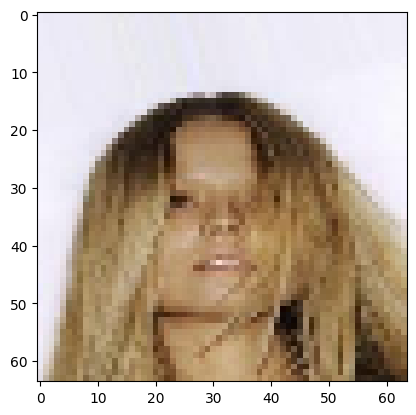

Label : img_align_celeba


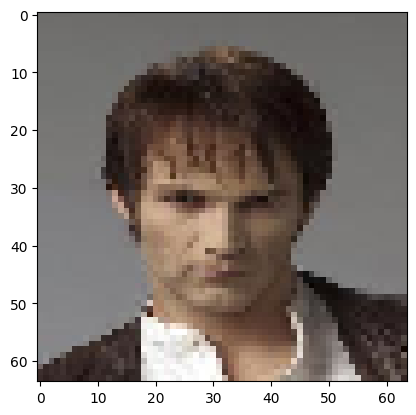

Label : img_align_celeba


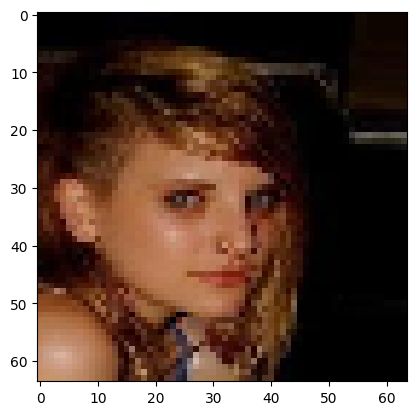

Label : img_align_celeba


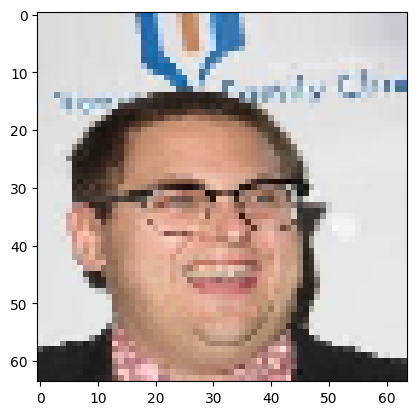

Label : img_align_celeba


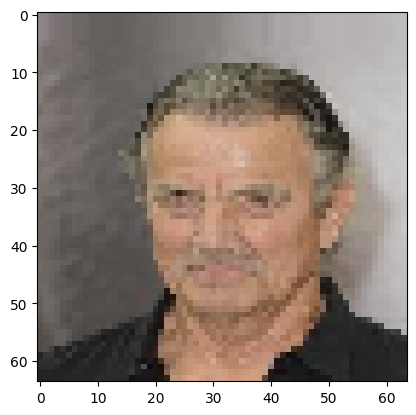

Label : img_align_celeba


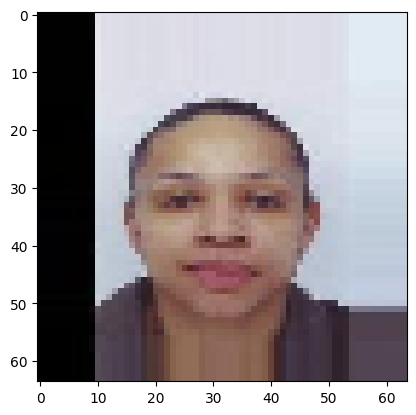

Label : img_align_celeba


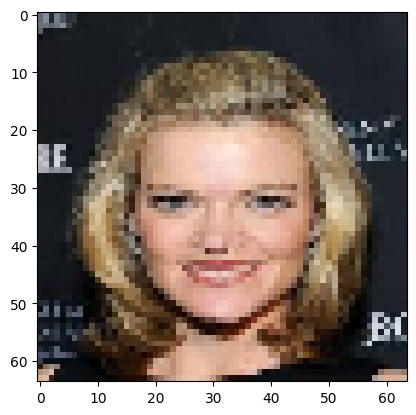

Label : img_align_celeba


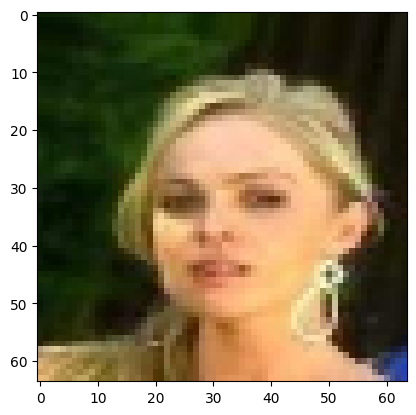

Label : img_align_celeba


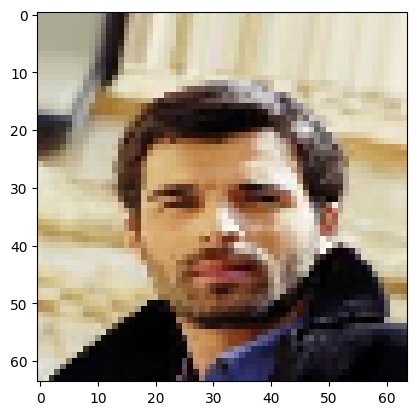

Label : img_align_celeba


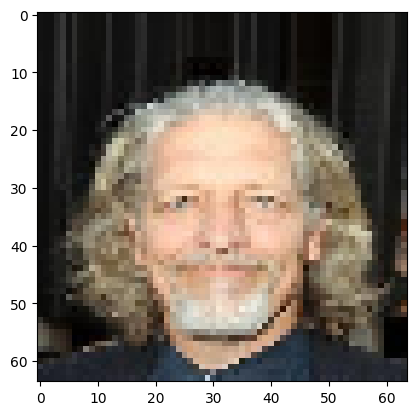

Label : img_align_celeba


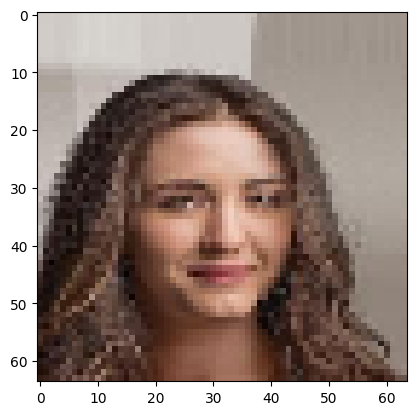

Label : img_align_celeba


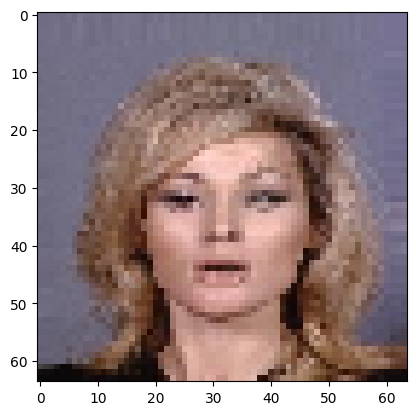

Label : img_align_celeba


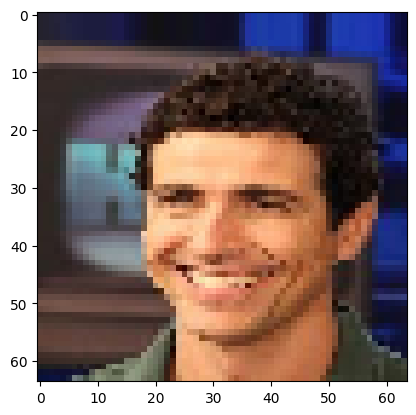

Label : img_align_celeba


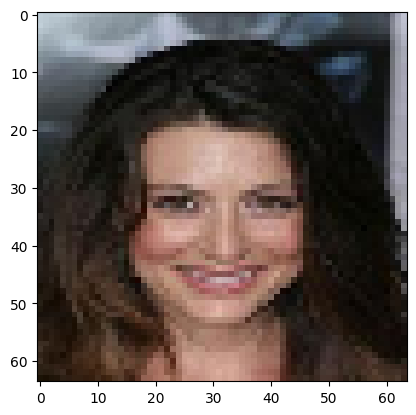

Label : img_align_celeba


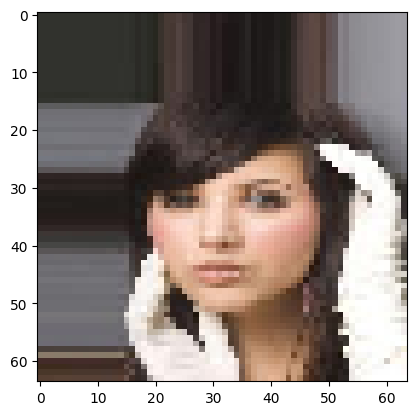

Label : img_align_celeba


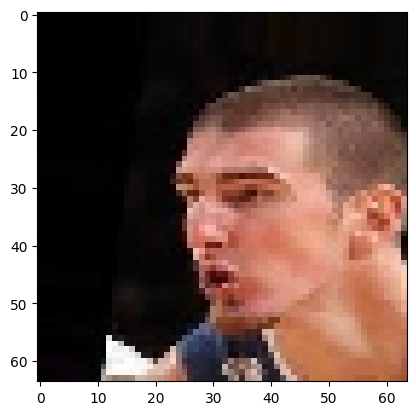

Label : img_align_celeba


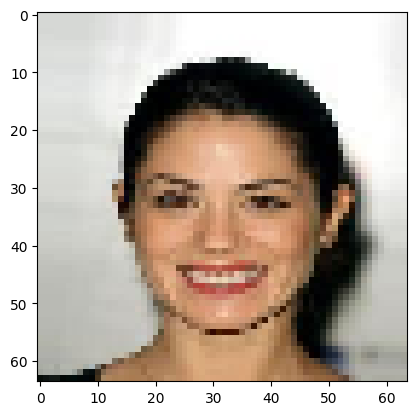

Label : img_align_celeba


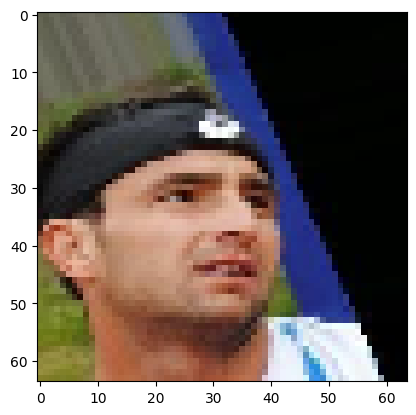

Label : img_align_celeba


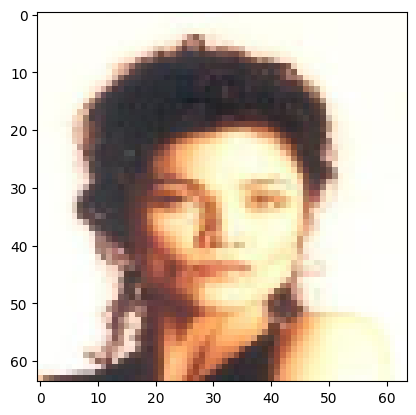

Label : img_align_celeba


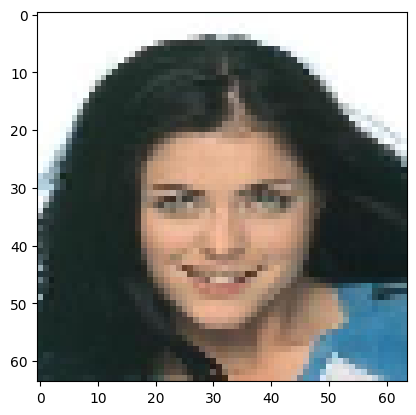

Label : img_align_celeba


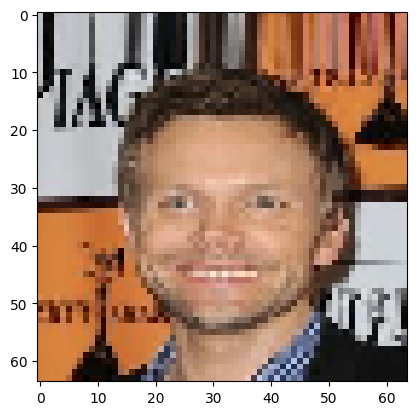

Label : img_align_celeba


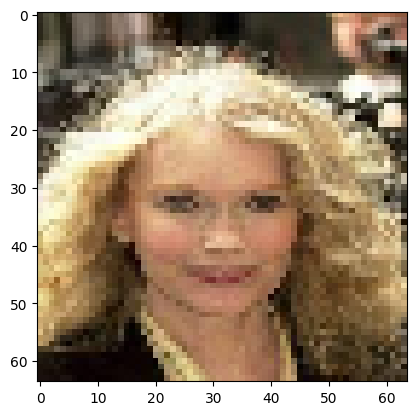

Label : img_align_celeba


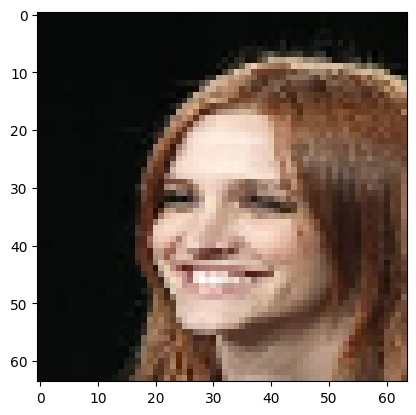

In [24]:
imgs, labels = next(iter(directory_generator))

for img, label in zip(imgs, labels):
    true_file_path = np.argmax(directory_generator.labels == tf.argmax(label))
    true_label_name = Path(directory_generator.filepaths[true_file_path]).parent.name
    print("Label :", true_label_name)
    plt.imshow(img)
    plt.show()

In [8]:
LATENT_DIM = 100
CHANNELS = 3

generator = tf.keras.Sequential([
  tf.keras.layers.Dense(4*4*512,  input_shape=(LATENT_DIM,)),
  tf.keras.layers.Reshape((4,4, 512)),
  tf.keras.layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False, activation="relu"), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False, activation="relu"), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(64, kernel_size=5,  strides=2, padding='same', use_bias=False, activation="relu"), 
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(3, kernel_size=5,  strides=2, padding='same', use_bias=False, activation="sigmoid") 
  ])

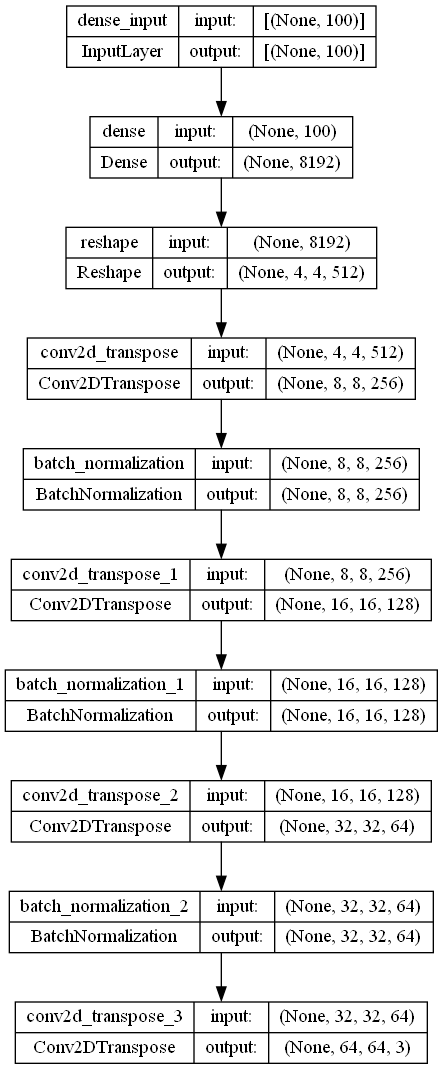

In [9]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3276800   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      819200    
 ranspose)                                                       
                                                        

1/1 [==============================] - 0s 247ms/step


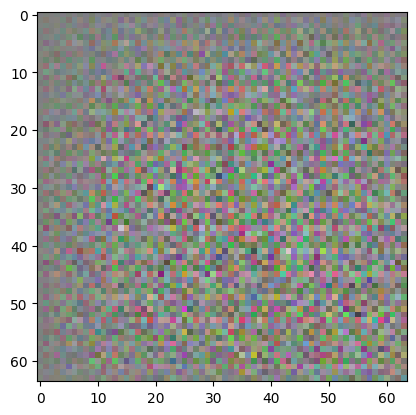

In [11]:
random_pixels = tf.random.normal([1,LATENT_DIM])*100
rand_img = generator.predict(random_pixels)
plt.imshow(tf.squeeze(rand_img))

In [12]:
discriminator = tf.keras.Sequential([        
        tf.keras.layers.Conv2D(64, (3, 3), strides=1,  activation="relu", padding='same', input_shape=imgs.shape[1:]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(128, (3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(256, (3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(512, (3, 3), strides=1, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="sigmoid")      
    ])

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                      

In [14]:
bce = tf.keras.losses.BinaryCrossentropy()

In [16]:
def discriminator_loss(real_outputs, fake_outputs):
  real_label = tf.ones_like(real_outputs) - 0.05 * tf.random.uniform(shape=real_outputs.shape)
  real_loss = bce(real_label, real_outputs) 
  fake_label = tf.zeros_like(fake_outputs) + 0.05 * tf.random.uniform(shape=fake_outputs.shape)
  fake_loss = bce(fake_label, fake_outputs) 
  
  total_loss = real_loss + fake_loss 
 
  return total_loss

In [17]:
def generator_loss(fake_outputs):
  return bce(tf.ones_like(fake_outputs), fake_outputs)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()

In [19]:
def train_step(images): 
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    noise_2 = tf.random.normal([BATCH_SIZE, LATENT_DIM]) 

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      generated_images_2 = generator(noise_2, training=True)

      

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True) 
      fake_output_2 = discriminator(generated_images_2, training=True) 


      gen_loss = generator_loss(fake_output_2) 
      disc_loss = discriminator_loss(real_output, fake_output) 

      
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) 
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    real_pred = real_output.numpy()>0.5
    fake_pred = fake_output.numpy()>0.5
    return real_pred, fake_pred, gen_loss, disc_loss

In [20]:
def generate_and_save_images(model, epoch, test_input):

  display.clear_output(wait=True)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 255,)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, LATENT_DIM])

NameError: name 'noise_dim' is not defined

In [ ]:
EPOCHS = 1
steps_per_epochs=5

for epoch in range(EPOCHS):
  start = time.time()
  real_score = 0
  real_len = 0
  fake_score = 0
  fake_len = 0
  for i in range(steps_per_epochs):
    image_batch,_ = next(iter(directory_generator))
    real_pred, fake_pred, gen_loss, disc_loss = train_step(image_batch)
    real_score += real_pred.sum()
    fake_score += fake_pred.sum()
    real_len += real_pred.shape[0]
    fake_len += fake_pred.shape[0]

  
  print("real pred", real_score/real_len)
  print("\n fake pred", fake_score/fake_len)
  print("disc loss", disc_loss)
  print("\n gen pred", gen_loss)

  generate_and_save_images(generator,
                           epoch + 1,
                           seed)

  print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
display.clear_output(wait=True)
generate_and_save_images(generator,
                         EPOCHS,
                         seed)

ValueError: Input 0 of layer "sequential_41" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(64, 64, 3)